In [3]:
%pylab inline
import pandas as pd
import numpy as np
import pickle
import copy as cp
import seaborn as sns
from ggplot import *
from sklearn.linear_model import SGDRegressor
from scipy import stats
from scipy.stats import binned_statistic, binned_statistic_dd
from sklearn.preprocessing import StandardScaler  
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import ExtraTreesRegressor, ExtraTreesClassifier
import itertools

plt.style.use('ggplot') 
pd.set_option('display.max_columns', None)

Populating the interactive namespace from numpy and matplotlib


/tigress/BEE/mimic/usr/np6/miniconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['legend', 'f', 'xlim', 'colors', 'ylim']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [ ]:
with open("pickles/fpreppedSamples7Mar.pkl",'rb') as f: 
    currStatesC, nextStatesC, actions, rewards, discretizedActions, discretizedActionSum = pickle.load(f)

In [3]:
feats= ['Age', 'Weight', 'Heart Rate', 'Respiratory Rate', '$SpO_2$', 
        'BP (Mean)', 'BP (Systolic)', 'BP (Diastolic)','$FiO_2$', 'PEEP set', 
        'Mean Airway Pressure', 'Ventilator Mode', 'Tidal Volume', 'Arterial pH', 'RR (Spont)', 
        'RASS','Peak Inspiratory Pressure', '$O_2$ Flow', 'Plateau Pressure','Arterial $O_2$ pressure', 
        'Arterial $CO_2$ pressure', 'Fentanyl (Conc)','Midazolam', 'Propofol', 'Fentanyl', 
        'Dexmedetomidine', 'Morphine', 'Hydromorphone', 'Lorazepam','Time on vent', 
        'Intubation number','Admit Type','Ethnicity','Male']

In [4]:
# Separate out different  patient trajectories:
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
scaler.fit(currStatesC)
currStatesScaled = scaler.transform(currStatesC)
nextStatesScaled = scaler.transform(nextStatesC)

samples = np.hstack((currStatesC, discretizedActionSum))
ptSamples = {}; ptStates = {}; ptActions = {}; ptRewards = {}; pts = {}
pt = -1; age = 0; wt = 0
for i in range(len(currStatesC)):
    if ((samples[i][0] == age) and (samples[i][1] == wt)):
        ptSamples[pt].append(samples[i]); ptStates[pt].append(currStatesScaled[i])
        ptActions[pt].append(discretizedActionSum[i]); ptRewards[pt].append(rewards[i])
        pts[pt].append(i)
    else:
        pt = pt + 1
        ptSamples[pt] = [samples[i]]; ptStates[pt] = [currStatesScaled[i]]
        ptActions[pt] = [discretizedActionSum[i]]; ptRewards[pt] = [rewards[i]]
        pts[pt] = [i]
    age = samples[i][0]; wt = samples[i][1]
    
trainPts = (pts.keys()[:1800])
testPts = (pts.keys()[1800:])
trainingSet = (np.hstack([pts[i] for i in trainPts]))

/tigress/BEE/mimic/usr/np6/miniconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [ ]:
actionChoices = (np.vstack({tuple(row) for row in discretizedActionSum}))
gamma = 0.9
alpha = 0.1

Q = np.zeros((len(actionChoices), len(trainingSet)))
Qnew = np.zeros((len(actionChoices), len(trainingSet)))
nActions = len(actionChoices)
estimator = []   
Qdist = []
for a in range(nActions):
    model = MLPRegressor(solver='adam', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
    model.fit([currStatesScaled[i] for i in trainingSet], [rewards[i] for i in trainingSet])
    Q[a, :] = model.predict([currStatesScaled[i] for i in trainingSet])
    estimator.append(model)
    
def aID(action):
    aID = np.where((actionChoices == (action[0], action[1])).all(axis=1))[0][0]
    return aID
    
while True:
    for ep in range(len(trainPts)):    
        state = ptStates[ep][0]
        action = ptActions[ep][0]
        td_target = np.zeros(len(ptStates[ep]))
        for i in range(len(ptStates[ep])-1):
            reward = ptRewards[ep][i]
            next_state = ptStates[ep][i+1]
            next_action = ptActions[ep][i+1]
            #Q[s,a] ←Q[s,a] + α(r+ γQ[s',a'] - Q[s,a])
            qest = estimator[aID(action)].predict(state.reshape(1,-1))
            td_target[i] = qest + alpha*(reward + (gamma * estimator[aID(next_action)].predict(next_state.reshape(1,-1))) - qest)
            estimator[aID(action)].partial_fit(state.reshape(1, -1), [td_target[i]])
            state = next_state
            action = next_action

        for a in range(nActions):
            Qnew[a, :] = estimator[a].predict([currStatesScaled[i] for i in trainingSet])
        Qdist.append(np.array(sum(abs(np.matrix(Qnew) - np.matrix(Q)))))
        print 'Pt:', ep, ', Qdist:', np.array(mean(abs(np.matrix(Qnew) - np.matrix(Q)))) 
        Q = cp.deepcopy(Qnew) 
    
print 'Done'

Pt: 0 , Qdist: 3.06732955852
Pt: 1 , Qdist: 9.30853243566
Pt: 2 , Qdist: 0.111499887795
Pt: 3 , Qdist: 1.97311611684
Pt: 4 , Qdist: 1.09523609482
Pt: 5 , Qdist: 1.39571297033
Pt: 6 , Qdist: 0.550431155009
Pt: 7 , Qdist: 0.281859342394
Pt: 8 , Qdist: 0.807450525992
Pt: 9 , Qdist: 6.26372794536
Pt: 10 , Qdist: 0.830130006784
Pt: 11 , Qdist: 2.78355182992
Pt: 12 , Qdist: 0.492111587728
Pt: 13 , Qdist: 0.147819920887
Pt: 14 , Qdist: 0.46616754662
Pt: 15 , Qdist: 1.37288182687
Pt: 16 , Qdist: 0.417310213492
Pt: 17 , Qdist: 4.59429409454
Pt: 18 , Qdist: 1.9208348124
Pt: 19 , Qdist: 0.263792082831
Pt: 20 , Qdist: 0.758920092384
Pt: 21 , Qdist: 0.2115243073
Pt: 22 , Qdist: 0.874843175961
Pt: 23 , Qdist: 0.370289316073
Pt: 24 , Qdist: 4.41331329999
Pt: 25 , Qdist: 0.275615599662
Pt: 26 , Qdist: 1.98971967603
Pt: 27 , Qdist: 1.33562065334
Pt: 28 , Qdist: 0.329579702296
Pt: 29 , Qdist: 1.16723400532
Pt: 30 , Qdist: 0.74850016831
Pt: 31 , Qdist: 0.180759998797
Pt: 32 , Qdist: 0.765018582508
Pt: 33

In [103]:
gamma*(estimator[aID(next_action)].predict(next_state.reshape(1,-1)) - qest

array([-14.63191815])

In [45]:
def fitTree(samples,targets):
    clf = ExtraTreesRegressor(n_estimators=50, max_depth=None, min_samples_leaf=50, random_state=1, warm_start=False)
    clf.fit(samples, targets)
    return clf
def fitNN(samples, targets):
    clf = MLPRegressor(solver='adam', alpha=1e-5, hidden_layer_sizes=(5,2), random_state=None)
    clf.fit(samples, targets)
    return clf
def partialfitNN(clf, samples, targets):
    clf.partial_fit(samples, targets)
    return clf
def fitCNN(states, actions) :
    clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(5,2), random_state=None)
    clf.fit(states, actions)
    return clf

batchSize = 50000
samples = np.hstack((currStatesScaled, discretizedActionSum))
actionChoices = (np.vstack({tuple(row) for row in discretizedActionSum}))

print 'Initialization'
batch = np.random.choice(trainingSet, batchSize, replace=False)
batch = trainingSet
#Qtree = fitTree([samples[s] for s in batch], [rewards[s] for s in batch])
Qnn = fitNN([samples[s] for s in batch], [rewards[s] for s in batch])
gamma = 0.9
Q = np.zeros((len(actionChoices), len(trainingSet)))
Qdist = []

print 'Q-iteration'
iter = 0 
while iter < 100:
    batch = np.random.choice(trainingSet, batchSize, replace=False)     
    S = {}
    Qold = cp.deepcopy(Q) 
    anum = 0
    for a in actionChoices:
        #Q[anum,batch] = Qtree.predict([np.hstack((nextStatesScaled[s], a)) for s in batch])
        Q[anum,batch] = Qnn.predict([np.hstack((nextStatesScaled[s], a)) for s in batch])
        anum += 1
    Qdist.append(np.array(mean(abs(np.matrix(Qold) - np.matrix(Q)))))
    
    optA = [np.argmax(np.transpose(Q[:,s])) for s in batch]
    T = [(rewards[s] + gamma*max(np.transpose(Q[:,s]))) for s in batch]
    #Qtree = fitTree([samples[s] for s in batch], T)
    Qnn = partialfitNN(Qnn, [samples[s] for s in batch], T)
    S = {'n': batch, 'T': T, 'optA': optA}
    print 'Iter:', iter, '; Qdiff:', Qdist[len(Qdist)-1]    
    iter = iter + 1

Initialization
Q-iteration
Iter: 0 ; Qdiff: 3.25357803722
Iter: 1 ; Qdiff: 5.36268211108
Iter: 2 ; Qdiff: 6.53020313251
Iter: 3 ; Qdiff: 6.99008648239
Iter: 4 ; Qdiff: 7.08461154783
Iter: 5 ; Qdiff: 6.98644676101
Iter: 6 ; Qdiff: 6.7769219637
Iter: 7 ; Qdiff: 6.61037941303
Iter: 8 ; Qdiff: 6.33152522795
Iter: 9 ; Qdiff: 6.0772545046
Iter: 10 ; Qdiff: 5.94539566287
Iter: 11 ; Qdiff: 5.81553671706
Iter: 12 ; Qdiff: 5.63360064999
Iter: 13 ; Qdiff: 5.58903290505
Iter: 14 ; Qdiff: 5.38773485387
Iter: 15 ; Qdiff: 5.20276907679
Iter: 16 ; Qdiff: 4.97573893927
Iter: 17 ; Qdiff: 4.57626395465
Iter: 18 ; Qdiff: 4.44804654804
Iter: 19 ; Qdiff: 4.22202599505
Iter: 20 ; Qdiff: 3.94008040055
Iter: 21 ; Qdiff: 3.7453972937
Iter: 22 ; Qdiff: 3.45293210534
Iter: 23 ; Qdiff: 3.29116834168
Iter: 24 ; Qdiff: 3.07646292743
Iter: 25 ; Qdiff: 2.78758496999
Iter: 26 ; Qdiff: 2.5630718635
Iter: 27 ; Qdiff: 2.30096209699
Iter: 28 ; Qdiff: 1.99368312776
Iter: 29 ; Qdiff: 1.82637437234
Iter: 30 ; Qdiff: 1.5878272

In [46]:
with open("pickles/misc13MarNN.pkl",'wb') as f:
    pickle.dump((Qnn, Q, Qold, Qdist, S, optA, actionChoices), f)

-----------------------------------

In [5]:
with open("pickles/misc13MarTree.pkl",'rb') as f: 
    Qtree, Q, Qold, Qdist, S, optA, actionChoices = pickle.load(f)
with open("pickles/misc13MarNN.pkl",'rb') as f: 
    Qnn, nnQ, nnQold, nnQdist, nnS, nnoptA, nnactionChoices = pickle.load(f)

In [ ]:
nnQdist = np.array(nnQdist)
qplot(range(len(nnQdist)), nnQdist)
ggplot(tmp, aes(x='Iteration Number $k$', y='FQI w/ Extra-Trees')) + geom_line()
tmp = pd.DataFrame(np.transpose([nnQdist, range(len(nnQdist))]), columns=['A', 'B'])
tmp2= pd.DataFrame(np.transpose([Qdist, range(len(Qdist))]), columns=['A', 'B'])
tmp = pd.DataFrame(np.transpose([np.arange(100), Qdist, nnQdist]), columns=['Iteration Number $k$', 'FQI w/ Extra-Trees', 'Neural Fitted-Q'])
tmp2 = pd.melt(tmp, id_vars='Iteration Number $k$')
ggplot(tmp2, aes(x='Iteration Number $k$', y='value', color='variable')) + geom_line(size = 2) + theme(x_axis_text=element_text(angle=0, size=12), y_axis_text=element_text(size=14)) + theme_bw() + ylab(element_text(size=15, text='Mean $\Delta (\hat{Q}_k, \hat{Q}_{k-1})$')) + xlab(element_text(size=15))

(array([ -2.,   0.,   2.,   4.,   6.,   8.,  10.]),
 <a list of 7 Text yticklabel objects>)

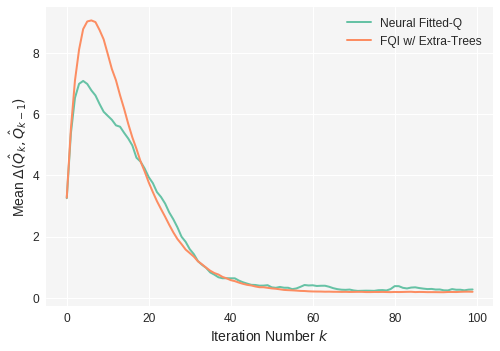

In [63]:
sns.set(rc={'axes.facecolor':'whitesmoke', 'figure.facecolor':'white', 'grid.color':'white'})
palette = itertools.cycle(sns.color_palette('Set2'))
hold(True)
plot(nnQdist, label='Neural Fitted-Q', linewidth=2, color=next(palette))
plot(Qdist, label='FQI w/ Extra-Trees', linewidth=2, color=next(palette))
plt.legend(fontsize=12)
plt.xlabel('Iteration Number $k$', size=14)
plt.ylabel('Mean $\Delta (\hat{Q}_k, \hat{Q}_{k-1})$', size=14)
plt.xticks(size=12)
plt.yticks(size=12)

In [64]:
def fitCtree(states, actions):
    clf = ExtraTreesClassifier(n_estimators=500, max_depth=None, min_samples_leaf=50, random_state=1, warm_start=False)
    clf.fit(states, actions)
    return clf
def plotImportances(Q):
    optA = [np.argmax(np.transpose(Q[:,s])) for s in trainingSet]
    policyTree = fitCtree([currStatesScaled[s] for s in trainingSet], optA) 
    use = [0, 1, 2, 3, 4, 5 ,6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 31, 32, 33]
    importances = policyTree.feature_importances_
    std = np.std([tree.feature_importances_ for tree in policyTree.estimators_],axis=0)
    featImportances = pd.DataFrame(data={"feats": [feats[x] for x in use], "importances": [importances[x] for x in use]}, index=[feats[x] for x in use])
    #featImportances.sort_values(by='importances',ascending=True).plot(kind="barh", xerr= [std[x] for x in use], legend=None, width=0.75, figsize=[12,7], color='#41B28B', fontsize=12)
    plt.xlabel("Feature Importance", size=14)
    return importances, featImportances

def plotImportances2(Q):
    optA = [np.argmax(np.transpose(Q[:,s])) for s in trainingSet]
    use = [0, 1, 2, 3, 4, 5 ,6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 31, 32, 33]
    policyTree = fitCtree([currStatesScaled[s][use] for s in trainingSet], optA) 
    importances = policyTree.feature_importances_
    std = np.std([tree.feature_importances_ for tree in policyTree.estimators_],axis=0)
    featImportances = pd.DataFrame(data={"feats": [feats[x] for x in use], "importances": importances}, index=[feats[x] for x in use])
    #featImportances.sort_values(by='importances',ascending=True).plot(kind="barh", xerr= [std[x] for x in use], legend=None, width=0.75, figsize=[12,7], color='#41B28B', fontsize=12)
    #plt.xlabel("Feature Importance", size=14)
    return importances, featImportances, policyTree

imp1, fi1, ptree1 = plotImportances2(Q)
imp2, fi2, ptree2 = plotImportances2(nnQ)


In [65]:
use = [0, 1, 2, 3, 4, 5 ,6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 31, 32, 33]

dpoints=np.transpose(np.hstack([
            np.vstack([['FQI w/ Extra-Trees']*len(use), [feats[x] for x in use], imp1]),
            np.vstack([['Neural Fitted-Q']*len(use), [feats[x] for x in use], imp2])
        ]))

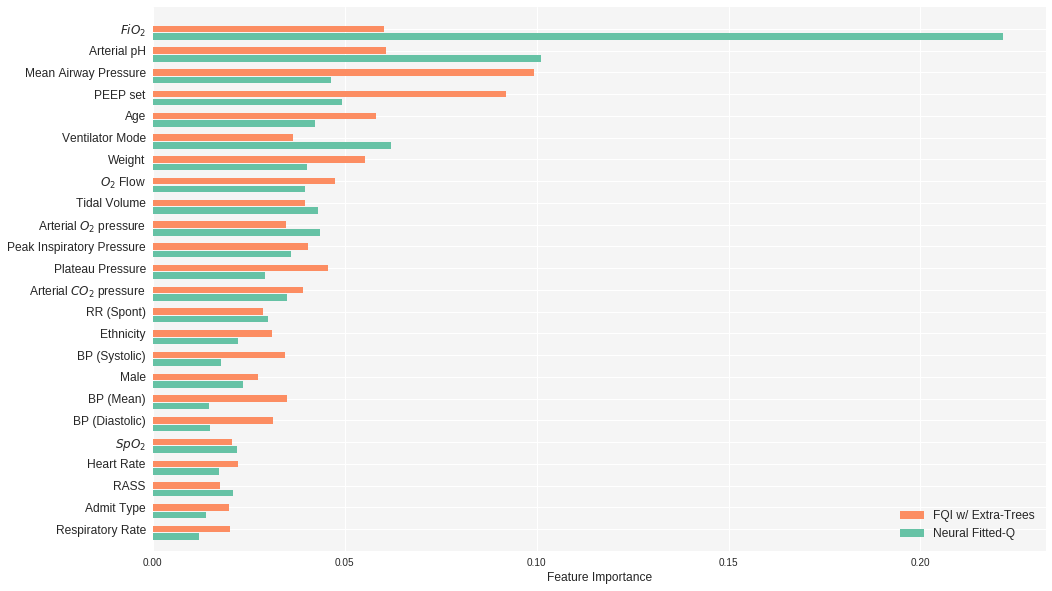

In [82]:
import matplotlib.cm as cm
import operator as o
import itertools

fig = plt.figure()
ax = plt.subplot()
fig.set_size_inches(16,10)

def barplot(ax, dpoints):
    '''
    Create a barchart for data across different categories with
    multiple conditions for each category.
    
    @param ax: The plotting axes from matplotlib.
    @param dpoints: The data set as an (n, 3) numpy array
    '''
    palette = itertools.cycle(sns.color_palette('Set2'))

    # Aggregate the conditions and the categories according to their
    # mean values
    conditions = [(c, np.mean(dpoints[dpoints[:,0] == c][:,2].astype(float))) 
                  for c in np.unique(dpoints[:,0])]
    categories = [(c, np.mean(dpoints[dpoints[:,1] == c][:,2].astype(float))) 
                  for c in np.unique(dpoints[:,1])]
    
    # sort the conditions, categories and data so that the bars in
    # the plot will be ordered by category and condition
    conditions = [c[0] for c in sorted(conditions, key=o.itemgetter(1))]
    categories = [c[0] for c in sorted(categories, key=o.itemgetter(1))]
    
    dpoints = np.array(sorted(dpoints, key=lambda x: categories.index(x[1])))

    # the space between each set of bars
    space = 0.3
    n = len(conditions)
    width = 0.3
    height = (1 - space) / (len(conditions))
    
    # Create a set of bars at each position
    for i,cond in enumerate(conditions):
        indeces = range(1, len(categories)+1)
        vals = dpoints[dpoints[:,0] == cond][:,2].astype(np.float)
        pos = [j - (1 - space) / 2. + i * height for j in indeces]
        ax.barh(pos, vals, height=width, label=cond, color=next(palette))
    
    # Set the x-axis tick labels to be equal to the categories
    ax.set_yticks(indeces)
    ax.set_yticklabels(categories, size=12)
    #plt.setp(plt.xticks()[1], rotation=0)
    
    # Add the axis labels
    ax.set_xlabel("Feature Importance",size=12)
    ax.set_ylabel("", size=12)
    ax.set_ylim([0, len(categories)+1])
    # Add a legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], loc='lower right',fontsize=12)
        
barplot(ax, dpoints)
plt.show()

In [46]:
## Testing ##

def piHosp(patient, adim): 
    pi = np.transpose(ptActions[patient])[adim]
    return pi
    
def piRL(patient, adim, fqi, policyTree):
    if fqi:
        pi = np.transpose(policyTree.predict(ptStates[patient]))[adim]
    else:
        pi = np.transpose(actionChoices[np.argmax(np.transpose([estimator[a].predict(ptStates[patient]) 
                                                                for a in range(7)]), axis=1)])[adim]
    return pi

total = {}; vMatches = {}; sMatches = {}
frac_vMatches = []; frac_sMatches = []; 
fqi = True
for patient in testPts:
    total[patient] = len(piHosp(patient, 0))
    vMatches[patient] = np.where(piHosp(patient, 0) - piRL(patient, 0, fqi, ptree1) == 0)[0]
    sMatches[patient] = np.where(abs(piHosp(patient, 1) - piRL(patient, 1, fqi, ptree1)) <= 1)[0]
    frac_vMatches.append(100 * len(vMatches[patient])/ float(total[patient])) 
    frac_sMatches.append(100 * len(sMatches[patient])/ float(total[patient])) 
    
frac_vMatches = np.asarray(frac_vMatches)
frac_sMatches = np.asarray(frac_sMatches)

NameError: global name 'policyTree' is not defined

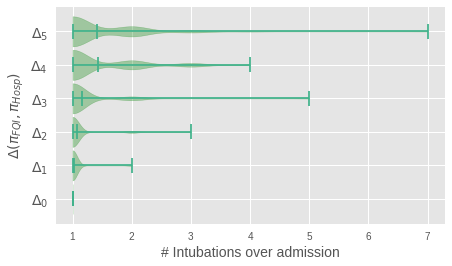

In [115]:
#bins = stats.mstats.mquantiles(frac_vMatches, [0, 1./5, 2./5, 3./5, 4./5, 1])
bins=[100, 93, 85, 65, 30, 0]    
dist0 = np.where(frac_vMatches >= bins[0])[0]
dist1 = np.where(np.logical_and((frac_vMatches >= bins[1]), (frac_vMatches < bins[0])))[0]
dist2 = np.where(np.logical_and((frac_vMatches >= bins[2]), (frac_vMatches < bins[1])))[0]
dist3 = np.where(np.logical_and((frac_vMatches >= bins[3]), (frac_vMatches < bins[2])))[0]
dist4 = np.where(np.logical_and((frac_vMatches >= bins[4]), (frac_vMatches < bins[3])))[0]
dist5 = np.where(np.logical_and((frac_vMatches >= bins[5]), (frac_vMatches < bins[4])))[0]
vdists = [dist0, dist1, dist2, dist3, dist4, dist5]

sbins=[100, 95, 85, 70, 30, 0]    
sdist0 = np.where(frac_sMatches >= sbins[0])[0]
sdist1 = np.where(np.logical_and((frac_sMatches >= sbins[1]), (frac_sMatches < sbins[0])))[0]
sdist2 = np.where(np.logical_and((frac_sMatches >= sbins[2]), (frac_sMatches < sbins[1])))[0]
sdist3 = np.where(np.logical_and((frac_sMatches >= sbins[3]), (frac_sMatches < sbins[2])))[0]
sdist4 = np.where(np.logical_and((frac_sMatches >= sbins[4]), (frac_sMatches < sbins[3])))[0]
sdist5 = np.where(np.logical_and((frac_sMatches >= sbins[5]), (frac_sMatches < sbins[4])))[0]
sdists = [sdist0, sdist1, sdist2, sdist3, sdist4, sdist5]

os = 1800; finHr = {}; nd=0
for d in sdists:
    #finHr[nd] = ([mean(ptRewards[i+os][:]) for i in d])                   # mean reward 
    finHr[nd] =  [ptSamples[i+os][len(ptSamples[i+os])-1][30] for i in d]   # num intubations
    nd = nd + 1
for i in np.where([finHr[5][l] == 0 for l in range(len(finHr[5]))])[0]: finHr[5][i] = 1 

pos = [1, 2, 3, 4, 5, 6]
data = [finHr[i] for i in range(0,6)]
figure(figsize=(7, 4))
fig = plt.subplot()
violin_parts = plt.violinplot(data, pos, vert=False, widths=0.9, showmeans=True, showextrema=True, showmedians=False)
fig.set_yticklabels(['','$\Delta_0$','$\Delta_1$','$\Delta_2$','$\Delta_3$','$\Delta_4$','$\Delta_5$'], size=14)
fig.set_xlabel('# Intubations over admission', size=14)
fig.set_ylabel('$\Delta(\pi_{FQI}, \pi_{Hosp})$', size=14)

for pc in violin_parts['bodies']: pc.set_facecolor('green'); pc.set_edgecolor('green')
for pc in ['cmeans', 'cmins', 'cmaxes', 'cbars']: violin_parts[pc].set_color('#41B28B')
plt.show()

---------------------------------

In [ ]:
# IRL: discretizing key features in state

inCriteria = [2, 3, 4, 8, 9, 13]
binEdges = (np.histogramdd(np.transpose(data[inCriteria]), bins=10)[1])
# 6 feats, each in 10 bins --> 1 000 000 possible states

In [ ]:
# defaultparams
seed = 0; iterations = 10; depth_step=1; init_depth=0

# Initialize vars
states = #zeros(6,10) ?
actions = [0, 1] # consider just extubation
iters = iterations - 1
depth = depth_step
initdep = init_depth

# Construct mapping from states to example actions
Eo = zeros(states, 1)
for i in range(len(example_samples)):
    

def firlprojectionfromtree(tree, leaves, states, actions, feature_data):
    
    
def firloptimization(Eo, Rold, ProjToLeaf, LeafToProj, FeatureMatch, mdp_data):

